# Import

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats, integrate
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib
# matplotlib.use('Agg')
sns.set_style("ticks")

# Utils

In [3]:
def smoother(x, a=0.0, w=10, mode="moving"):
    if mode == "moving":
        y = [x[0]]
        for i in range(1, len(x)):
            y.append((1 - a) * x[i] + a * y[i - 1])
    elif mode == "window":
        y = []
        for i in range(len(x)):
            y.append(np.mean(x[max(i - w, 0):i + 1]))
    return y


def plot_single(df, title=None):
    plt.figure(figsize=(4, 3), dpi=100)
    x = df["exploration/num steps total"].to_numpy() / 1e6
    y = smoother(df["evaluation/Average Returns"].to_numpy(), w=10, mode="window")
    plt.xlabel("Million Steps")
    plt.ylabel("Average Return")
    if title:
        plt.title(title)
    plt.plot(x, y)


def plot_multi(dfs, labels, title=None):
    plt.figure(figsize=(8, 6), dpi=100)
    for df, label in zip(dfs, labels):
        x = df["exploration/num steps total"].to_numpy() / 1e6
        y = smoother(df["evaluation/Average Returns"].to_numpy(), w=10, mode="window")
        plt.plot(x, y, label=label)
    plt.xlabel("Million Steps")
    plt.ylabel("Average Return")
    if title:
        plt.title(title)
    plt.legend()


def plot_curve(
        ax,
        dfs,
        label=None,
        shaded_err=False,
        shaded_std=True,
        shared_area=0.5,
        steps_per_epoch=1000,
        context="Return/Average",
        color="black",
        **plot_kwargs,
):
    N = np.min([len(df) for df in dfs])
    x = dfs[0]["Diagnostics/Iteration"].to_numpy()[:N] * steps_per_epoch / 1e6
    ys = [smoother(df[f"{context}"].to_numpy()[:N], a=0.95) for df in dfs]
    y_mean = np.mean(ys, axis=0)
    if label is None:
        lin = ax.plot(x, y_mean, color=color, **plot_kwargs)
        # plt.semilogy(x, y_mean, color=color)
    else:
        lin = ax.plot(x, y_mean, label=label, color=color, **plot_kwargs)
    if len(ys) > 1:
        y_std = np.std(ys, axis=0) * shared_area
        y_stderr = y_std / np.sqrt(len(ys))
        if shaded_err:
            ax.fill_between(x, y_mean - y_stderr, y_mean + y_stderr, color=color, alpha=.4)
        if shaded_std:
            ax.fill_between(x, y_mean - y_std, y_mean + y_std, color=color, alpha=.2)
    return lin

def plot_curve_topk(
        ax,
        dfs,
        topk=3,
        label=None,
        shaded_err=False,
        shaded_std=True,
        shared_area=0.5,
        steps_per_epoch=1000,
        context="Return/Average",
        color="black",
        **plot_kwargs,
):
    N = np.min([len(df) for df in dfs])
    x = dfs[0]["Diagnostics/Iteration"].to_numpy()[:N] * steps_per_epoch / 1e6
#     ys = [smoother(df[f"{context}"].to_numpy()[:N], a=0.) for df in dfs]
    ys = [df[f"{context}"].to_numpy()[:N] for df in dfs]
    print(N, np.sort(np.array(ys), axis=0))
    ys = np.sort(np.array(ys), axis=0)[-topk:]
    y_mean = np.mean(ys, axis=0)
    if label is None:
        lin = ax.plot(x, y_mean, color=color, **plot_kwargs)
    else:
        lin = ax.plot(x, y_mean, label=label, color=color, **plot_kwargs)
    if len(ys) > 1:
        y_std = np.std(ys, axis=0) * shared_area
        y_stderr = y_std / np.sqrt(len(ys))
        if shaded_err:
            ax.fill_between(x, y_mean - y_stderr, y_mean + y_stderr, color=color, alpha=.4)
        if shaded_std:
            ax.fill_between(x, y_mean - y_std, y_mean + y_std, color=color, alpha=.2)
    return lin

# Experienment

## 0106

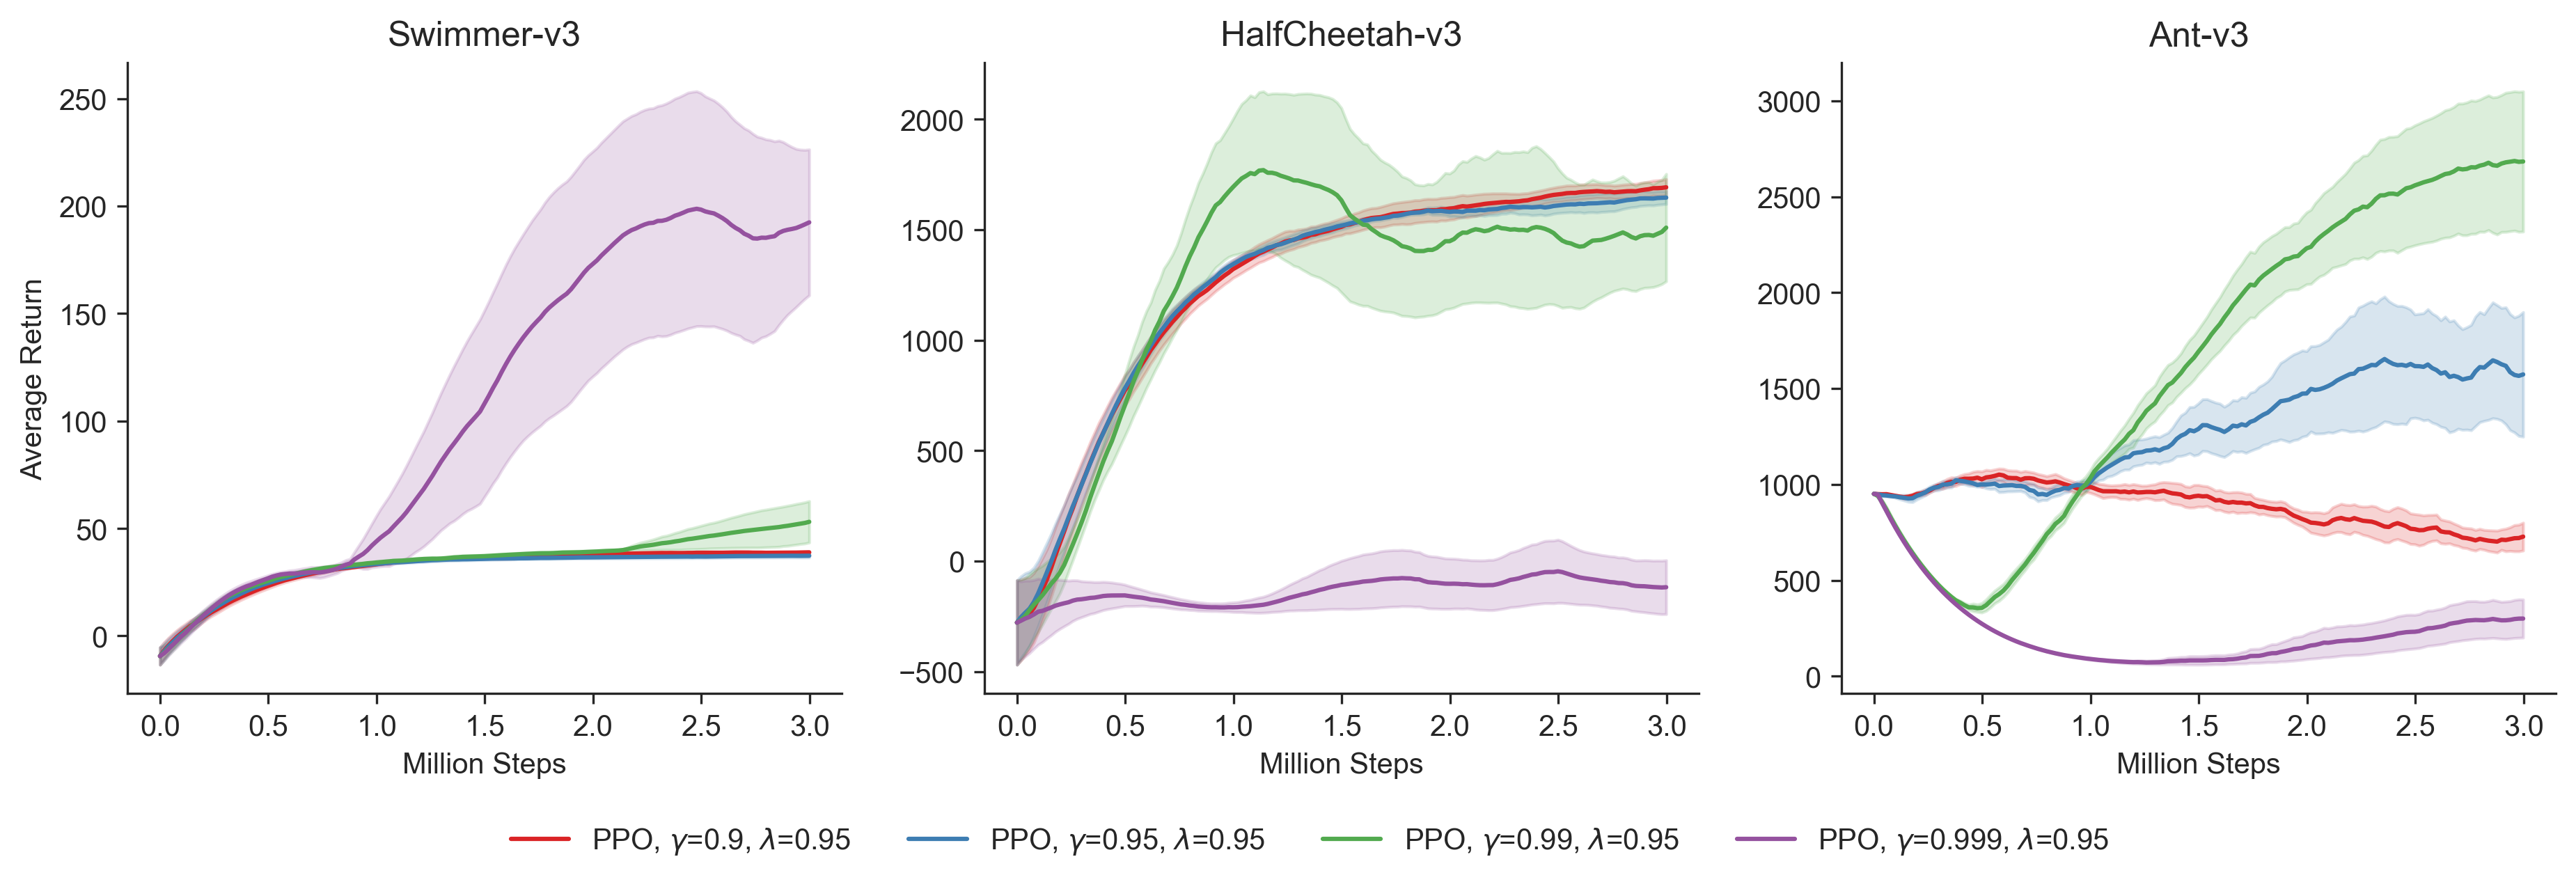

In [17]:
# compare PPO with different gamma
COLORS = sns.color_palette("Set1", 5, 0.9)
LINES = ["-", "--", ":", "-.", "-"]
fig = plt.figure(figsize=(15, 4), dpi=300)
fig.subplots_adjust(hspace=0.4)
for j, exp in enumerate(["Swimmer-v3", "HalfCheetah-v3", "Ant-v3"]):
# for j, exp in enumerate(["Hopper-v3", "Walker2d-v3", "Humanoid-v3"]):
    ax = fig.add_subplot(1, 3, j + 1)
    algo = "ppo"
    lamda = 0.95
    for i, gamma in enumerate([0.9, 0.95, 0.99, 0.999]):
        steps_per_epoch = 2000
        basedir = f"ppo_0107/data/{algo}_g-{gamma}_l-{lamda}_{exp}"
        dfs = [
            pd.read_csv(os.path.join(basedir, subdir, "progress.csv")) for subdir in os.listdir(basedir)
            if subdir.startswith("run_")
        ]
        plot_curve(ax, 
                   dfs, 
                   label=r"PPO, $\gamma$=" + str(gamma) + r", $\lambda$=" + str(lamda), 
                   color=COLORS[i], 
                   steps_per_epoch=steps_per_epoch, 
#                    linestyle=LINES[i],
                   context="Return/Average")
#                     context="Reward/Average")
    ax.set_title(exp)
    ax.set_xlabel("Million Steps")
    if j == 0:
        ax.set_ylabel("Average Return")
        ax.legend(loc="lower left", bbox_to_anchor=(0.5, -0.3), ncol=4, frameon=False)
#     ax.set_xlim(0, 1) if j < 2 else ax.set_xlim(0, 3)
#     if j == 2:
#         ax.legend(loc="upper left", frameon=False)
sns.despine()
plt.show()
# fig.savefig('result/baselines.pdf', dpi=300, bbox_inches='tight')

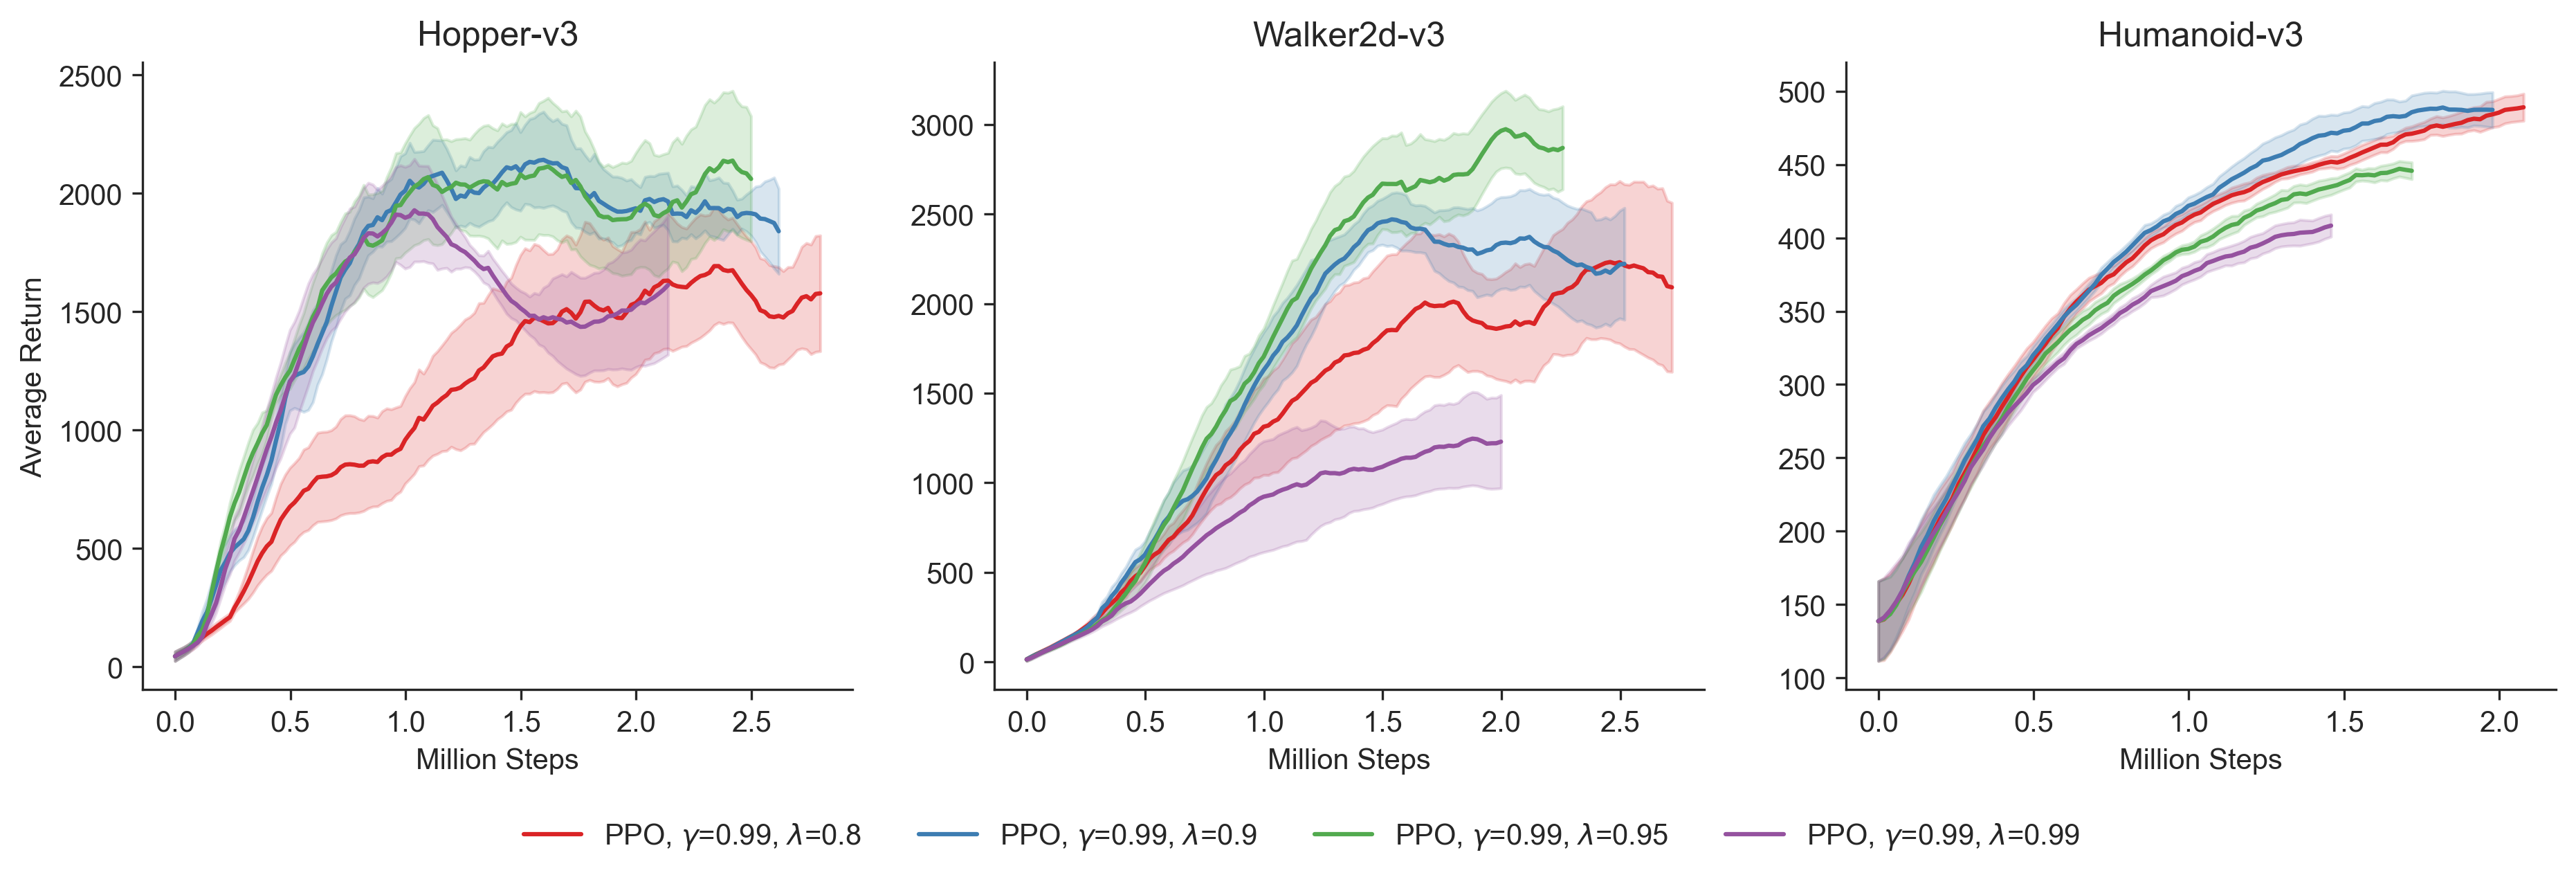

In [16]:
# compare PPO with different lamda
COLORS = sns.color_palette("Set1", 5, 0.9)
LINES = ["-", "--", ":", "-.", "-"]
fig = plt.figure(figsize=(15, 4), dpi=300)
fig.subplots_adjust(hspace=0.4)
# for j, exp in enumerate(["Swimmer-v3", "HalfCheetah-v3", "Ant-v3"]):
for j, exp in enumerate(["Hopper-v3", "Walker2d-v3", "Humanoid-v3"]):
    ax = fig.add_subplot(1, 3, j + 1)
    algo = "ppo"
    gamma = 0.99
    for i, lamda in enumerate([0.8, 0.9, 0.95, 0.99]):
        steps_per_epoch = 2000
        basedir = f"ppo_0107/data/{algo}_g-{gamma}_l-{lamda}_{exp}"
        dfs = [
            pd.read_csv(os.path.join(basedir, subdir, "progress.csv")) for subdir in os.listdir(basedir)
            if subdir.startswith("run_")
        ]
        plot_curve(ax, 
                   dfs, 
                   label=r"PPO, $\gamma$=" + str(gamma) + r", $\lambda$=" + str(lamda), 
                   color=COLORS[i], 
                   steps_per_epoch=steps_per_epoch, 
#                    linestyle=LINES[i],
                   context="Return/Average")
    ax.set_title(exp)
    ax.set_xlabel("Million Steps")
    if j == 0:
        ax.set_ylabel("Average Return")
        ax.legend(loc="lower left", bbox_to_anchor=(0.5, -0.3), ncol=4, frameon=False)
#     ax.set_xlim(0, 1) if j < 2 else ax.set_xlim(0, 3)
#     if j == 2:
#         ax.legend(loc="upper left", frameon=False)
sns.despine()
plt.show()
# fig.savefig('result/baselines.pdf', dpi=300, bbox_inches='tight')

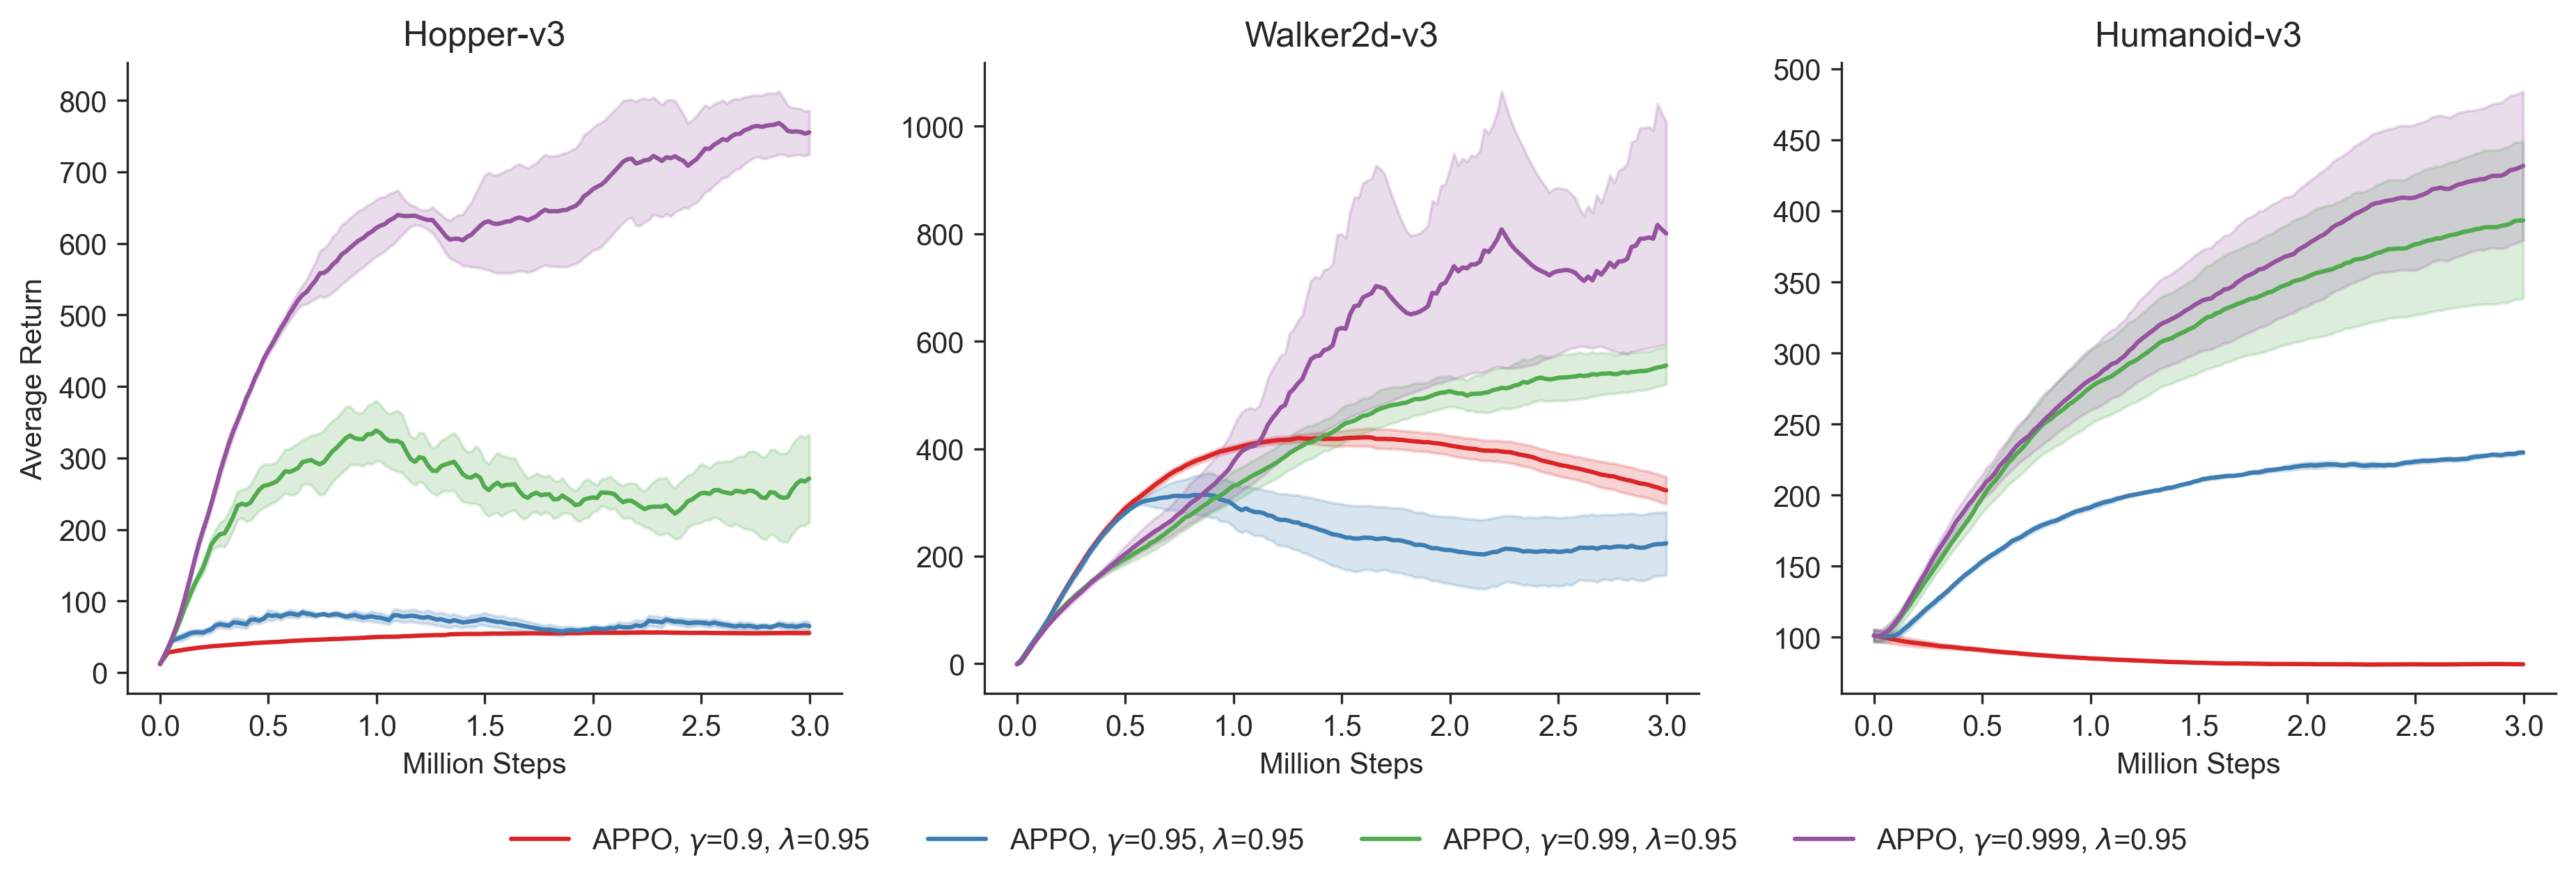

In [22]:
# compare APPO with different gamma
COLORS = sns.color_palette("Set1", 5, 0.9)
LINES = ["-", "--", ":", "-.", "-"]
fig = plt.figure(figsize=(15, 4), dpi=300)
fig.subplots_adjust(hspace=0.4)
# for j, exp in enumerate(["Swimmer-v3", "HalfCheetah-v3", "Ant-v3"]):
for j, exp in enumerate(["Hopper-v3", "Walker2d-v3", "Humanoid-v3"]):
    ax = fig.add_subplot(1, 3, j + 1)
    algo = "appo"
    lamda = 0.95
    for i, gamma in enumerate([0.9, 0.95, 0.99, 0.999]):
        steps_per_epoch = 2000
        basedir = f"data/{algo}_g-{gamma}_l-{lamda}_e-0.1_v-0.0_{exp}"
        dfs = [
            pd.read_csv(os.path.join(basedir, subdir, "progress.csv")) for subdir in os.listdir(basedir)
            if not subdir.startswith(".")
        ]
        plot_curve(ax, 
                   dfs, 
                   label=r"APPO, $\gamma$=" + str(gamma) + r", $\lambda$=" + str(lamda), 
                   color=COLORS[i], 
                   steps_per_epoch=steps_per_epoch, 
#                    linestyle=LINES[i],
                   context="Return/Average")
    ax.set_title(exp)
    ax.set_xlabel("Million Steps")
    if j == 0:
        ax.set_ylabel("Average Return")
        ax.legend(loc="lower left", bbox_to_anchor=(0.5, -0.3), ncol=4, frameon=False)
#     ax.set_xlim(0, 1) if j < 2 else ax.set_xlim(0, 3)
#     if j == 2:
#         ax.legend(loc="upper left", frameon=False)
sns.despine()
plt.show()
# fig.savefig('result/baselines.pdf', dpi=300, bbox_inches='tight')

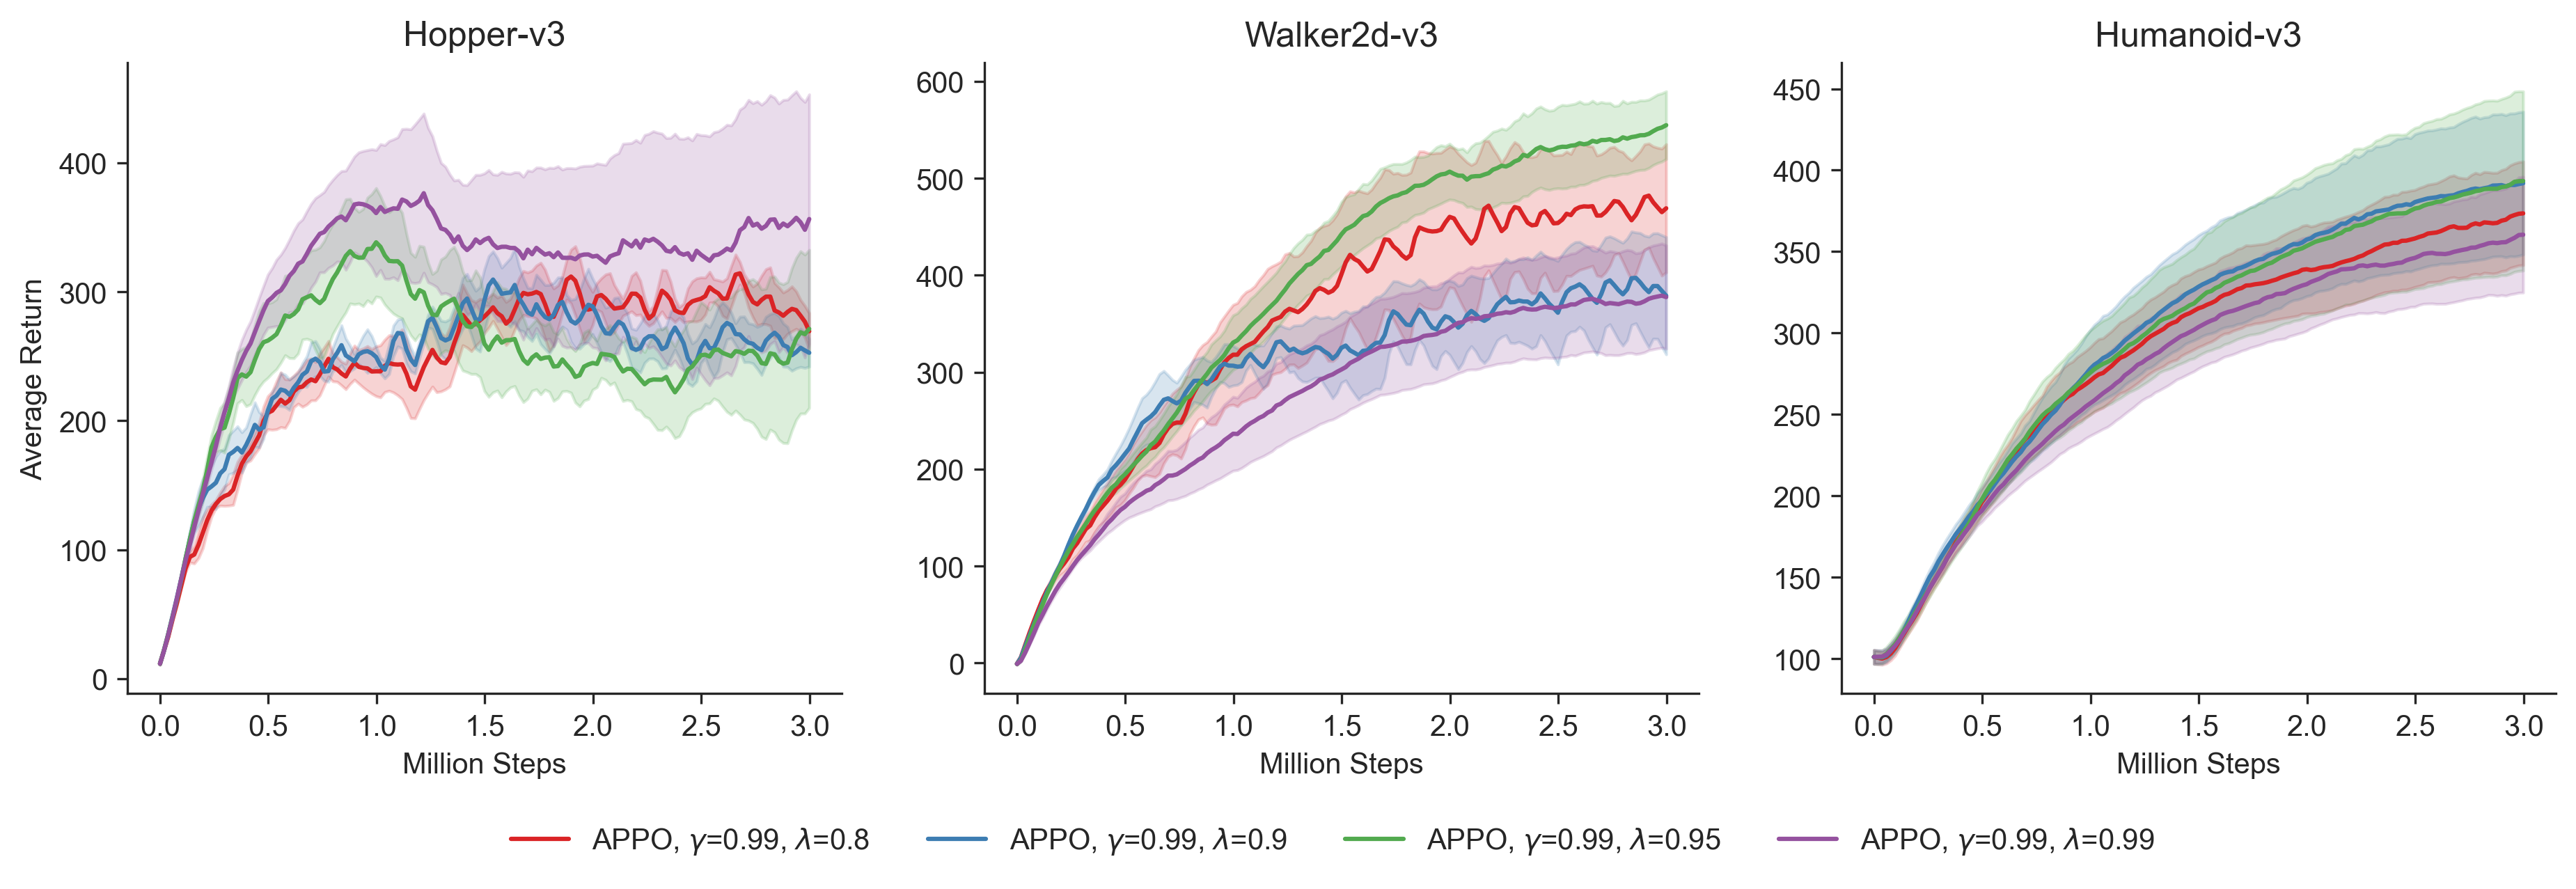

In [23]:
# compare APPO with different lamda
COLORS = sns.color_palette("Set1", 5, 0.9)
LINES = ["-", "--", ":", "-.", "-"]
fig = plt.figure(figsize=(15, 4), dpi=300)
fig.subplots_adjust(hspace=0.4)
# for j, exp in enumerate(["Swimmer-v3", "HalfCheetah-v3", "Ant-v3"]):
for j, exp in enumerate(["Hopper-v3", "Walker2d-v3", "Humanoid-v3"]):
    ax = fig.add_subplot(1, 3, j + 1)
    algo = "appo"
    gamma = 0.99
    for i, lamda in enumerate([0.8, 0.9, 0.95, 0.99]):
        steps_per_epoch = 2000
        basedir = f"data/{algo}_g-{gamma}_l-{lamda}_e-0.1_v-0.0_{exp}"
        dfs = [
            pd.read_csv(os.path.join(basedir, subdir, "progress.csv")) for subdir in os.listdir(basedir)
            if not subdir.startswith(".")
        ]
        plot_curve(ax, 
                   dfs, 
                   label=r"APPO, $\gamma$=" + str(gamma) + r", $\lambda$=" + str(lamda), 
                   color=COLORS[i], 
                   steps_per_epoch=steps_per_epoch, 
#                    linestyle=LINES[i],
                   context="Return/Average")
    ax.set_title(exp)
    ax.set_xlabel("Million Steps")
    if j == 0:
        ax.set_ylabel("Average Return")
        ax.legend(loc="lower left", bbox_to_anchor=(0.5, -0.3), ncol=4, frameon=False)
#     ax.set_xlim(0, 1) if j < 2 else ax.set_xlim(0, 3)
#     if j == 2:
#         ax.legend(loc="upper left", frameon=False)
sns.despine()
plt.show()
# fig.savefig('result/baselines.pdf', dpi=300, bbox_inches='tight')

FileNotFoundError: [Errno 2] No such file or directory: 'data/appo_g-1.0_l-0.95_e-0.1_v-0.0_Hopper-v3'

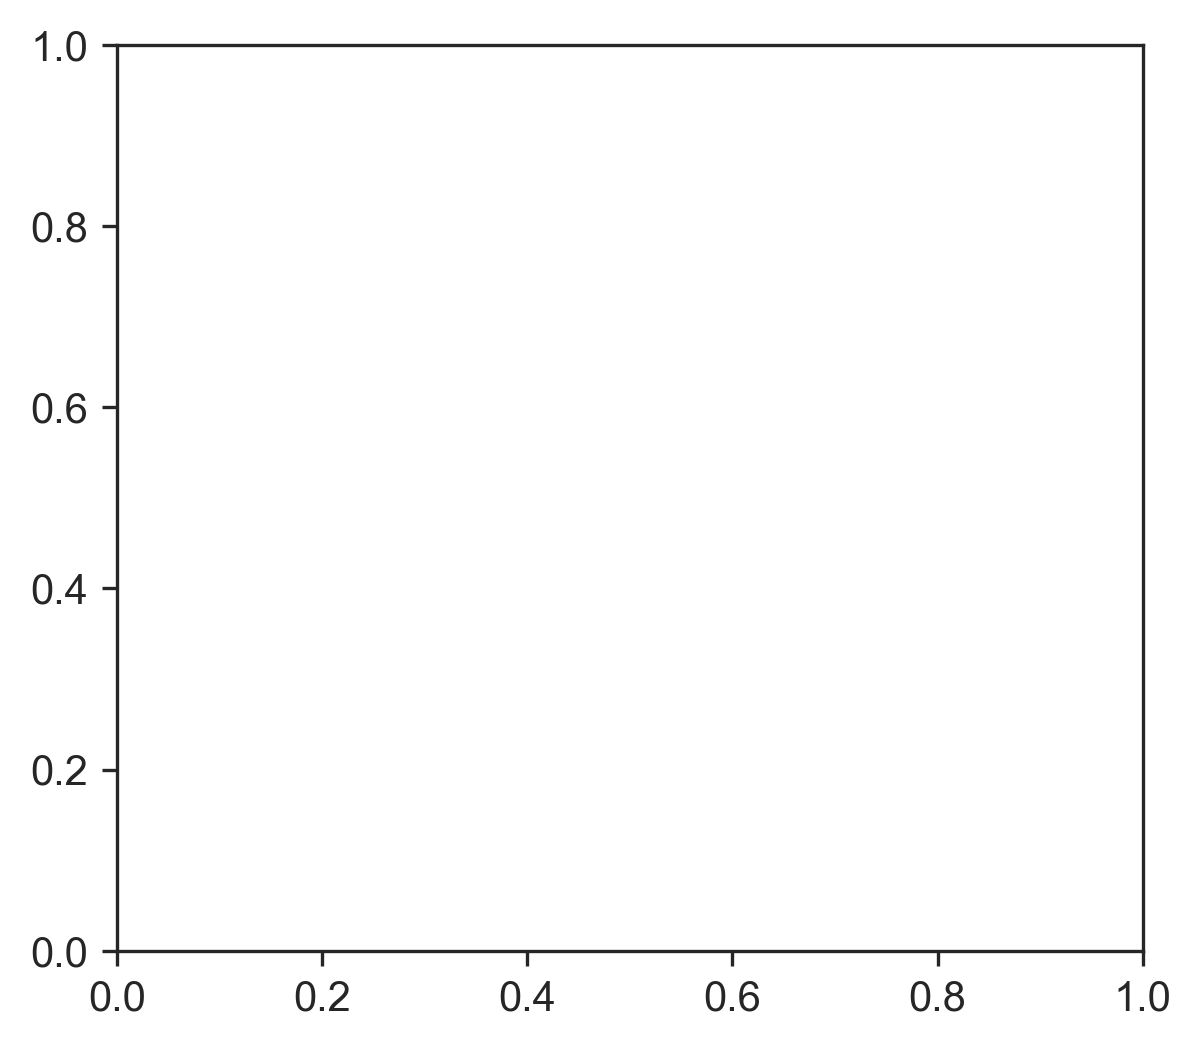

In [24]:
# compare APPO with different rm_vb_coef
COLORS = sns.color_palette("Set1", 5, 0.9)
LINES = ["-", "--", ":", "-.", "-"]
fig = plt.figure(figsize=(15, 4), dpi=300)
fig.subplots_adjust(hspace=0.4)
# for j, exp in enumerate(["Swimmer-v3", "HalfCheetah-v3", "Ant-v3"]):
for j, exp in enumerate(["Hopper-v3", "Walker2d-v3", "Humanoid-v3"]):
    ax = fig.add_subplot(1, 3, j + 1)
    algo = "appo"
    gamma=1.0
    lamda = 0.95
    lr_eta=0.1
    for i, rm_vb_coef in enumerate([0.0, 0.03, 0.1, 0.3, 1.0]):
        steps_per_epoch = 2000
        basedir = f"data/{algo}_g-{gamma}_l-{lamda}_e-{lr_eta}_v-{rm_vb_coef}_{exp}"
        dfs = [
            pd.read_csv(os.path.join(basedir, subdir, "progress.csv"))[1:] for subdir in os.listdir(basedir)
            if not subdir.startswith(".")
        ]
        plot_curve(ax, 
                   dfs, 
                   label=r"APPO, rm_vb_coef=" + str(rm_vb_coef), 
                   color=COLORS[i], 
                   steps_per_epoch=steps_per_epoch, 
#                    linestyle=LINES[i],
#                    context="Return/Average")
                     context="Reward/Average")
#                    context="valueBias/Average")
    ax.set_title(exp)
    ax.set_xlabel("Million Steps")
    if j == 0:
        ax.set_ylabel("Average Return")
#         ax.set_ylabel("Value Bias")
        ax.legend(loc="lower left", bbox_to_anchor=(0.1, -0.3), ncol=5, frameon=False)
#     ax.set_xlim(0, 1) if j < 2 else ax.set_xlim(0, 3)
#     if j == 2:
#         ax.legend(loc="upper left", frameon=False)
sns.despine()
plt.show()
# fig.savefig('result/baselines.pdf', dpi=300, bbox_inches='tight')

In [ ]:
# compare APPO with different rm_vb_coef
COLORS = sns.color_palette("Set1", 5, 0.9)
LINES = ["-", "--", ":", "-.", "-"]
fig = plt.figure(figsize=(15, 4), dpi=300)
fig.subplots_adjust(hspace=0.4)
for j, exp in enumerate(["Swimmer-v3", "HalfCheetah-v3", "Ant-v3"]):
    ax = fig.add_subplot(1, 3, j + 1)
    algo = "appo"
    gamma=1.0
    lamda=0.95
    rm_vb_coef=0.1
    for i, lr_eta in enumerate([0.03, 0.1, 0.3]):
        steps_per_epoch = 2000
        basedir = f"data/{algo}_g-{gamma}_l-{lamda}_e-{lr_eta}_v-{rm_vb_coef}_{exp}"
        dfs = [
            pd.read_csv(os.path.join(basedir, subdir, "progress.csv")) for subdir in os.listdir(basedir)
            if not subdir.startswith(".")
        ]
        plot_curve(ax, 
                   dfs, 
                   label=r"APPO, lr_eta=" + str(lr_eta), 
                   color=COLORS[i], 
                   steps_per_epoch=steps_per_epoch, 
#                    linestyle=LINES[i],
                   context="Return/Average")
    ax.set_title(exp)
    ax.set_xlabel("Million Steps")
    if j == 0:
        ax.set_ylabel("Average Return")
        ax.legend(loc="lower left", bbox_to_anchor=(0.9, -0.3), ncol=3, frameon=False)
#     ax.set_xlim(0, 1) if j < 2 else ax.set_xlim(0, 3)
#     if j == 2:
#         ax.legend(loc="upper left", frameon=False)
sns.despine()
plt.show()
# fig.savefig('result/baselines.pdf', dpi=300, bbox_inches='tight')

In [ ]:
# compare APPO and PPO with best parameters above
COLORS = sns.color_palette("Set1", 5, 0.9)
LINES = ["-", "--", ":", "-.", "-"]
fig = plt.figure(figsize=(15, 4), dpi=300)
fig.subplots_adjust(hspace=0.4)

exp_list = {
    "Swimmer-v3": ["appo_g-0.999_l-0.99_e-0.03_v-0.3_Swimmer-v3", "ppo_g-0.999_l-0.99_Swimmer-v3"],
    "HalfCheetah-v3": ["appo_g-0.999_l-0.9_e-0.1_v-1.0_HalfCheetah-v3", "ppo_g-0.9_l-0.9_HalfCheetah-v3"],
#     "Ant-v3": ["appo_g-0.99_l-0.95_e-0.3_v-0.3_Ant-v3", "ppo_g-0.99_l-0.8_Ant-v3"],
    "Ant-v3": ["appo_g-1.0_l-0.95_e-0.1_v-0.3_Ant-v3", "ppo_g-0.99_l-0.8_Ant-v3"],
}    


for j, exp in enumerate(["Swimmer-v3", "HalfCheetah-v3", "Ant-v3"]):
    ax = fig.add_subplot(1, 3, j + 1)
    for i, exp_name in enumerate(exp_list[exp]):
        steps_per_epoch = 2000
        basedir = f"data/{exp_name}"
        dfs = [
            pd.read_csv(os.path.join(basedir, subdir, "progress.csv")) for subdir in os.listdir(basedir)
            if not subdir.startswith(".")
        ]
        plot_curve(ax, 
                   dfs, 
                   label=exp_name, 
                   color=COLORS[i], 
                   steps_per_epoch=steps_per_epoch, 
#                    linestyle=LINES[i],
#                    context="Return/Average")
                context="Reward/Average")
    ax.set_title(exp)
    ax.set_xlabel("Million Steps")
    if j == 0:
        ax.set_ylabel("Average Return")
        ax.legend(loc="lower left", bbox_to_anchor=(0.9, -0.3), ncol=3, frameon=False)
#     ax.set_xlim(0, 1) if j < 2 else ax.set_xlim(0, 3)
#     if j == 2:
#         ax.legend(loc="upper left", frameon=False)
sns.despine()
plt.show()
# fig.savefig('result/baselines.pdf', dpi=300, bbox_inches='tight')